# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Initial Statistical Analysis


In [1]:
# imports 
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
import datetime as dt
import warnings
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.stats import norm

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import MSTL

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs

# box-cox transformation for skeewed data
from scipy.stats import boxcox, norm
from scipy.special import inv_boxcox

%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### *Load*

In [2]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowDataImputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index)

dmas = list(inflow_data.columns)

# # print first two rows
inflow_data.head(3)


dma_a  dma_b  dma_c  dma_d  dma_e  dma_f  dma_g  dma_h  \
date_time                                                                     
2021-01-01 00:00:00   5.65   8.79   3.70  32.29  72.59   7.23  22.37  16.71   
2021-01-01 01:00:00   5.30   8.72   3.56  32.63  73.93   8.25  19.65  16.57   
2021-01-01 02:00:00   7.31   8.21   3.27  26.24  58.66   5.43  17.43  12.82   

                     dma_i  dma_j  
date_time                          
2021-01-01 00:00:00  17.77  24.11  
2021-01-01 01:00:00  17.50  22.75  
2021-01-01 02:00:00  17.36  21.57

In [3]:
# load weather data
weather_data = pd.read_csv("../data/WeatherDataImputed.csv")

weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1
        
weather_data.head(5)

rain_depth  air_temp  air_humid  windspeed  \
date_time                                                         
2021-01-01 00:00:00        0.00      7.20      79.00       9.00   
2021-01-01 01:00:00        0.00      7.30      79.00       6.00   
2021-01-01 02:00:00        0.00      7.60      78.00       4.00   
2021-01-01 03:00:00        0.00      8.20      75.00       4.00   
2021-01-01 04:00:00        0.00      7.70      77.00       7.00   

                     official_holiday  legally_not_recongnized_holidays  \
date_time                                                                 
2021-01-01 00:00:00                 1                                 0   
2021-01-01 01:00:00                 1                                 0   
2021-01-01 02:00:00                 1                                 0   
2021-01-01 03:00:00                 1                                 0   
2021-01-01 04:00:00                 1                                 0   

                     event_day  weekend  
date_time                                
2021-01-01 00:00:00          0        0  
2021-01-01 01:00:00          0        0  
2021-01-01 02:00:00          0        0  
2021-01-01 03:00:00          0        0  
2021-01-01 04:00:00          0        0

### Statistical Models

#### 1. Data Preparation

In [4]:
# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]


#### 1.1 Transforms

In [5]:
# find best boxcox transformation. Include datetime index if given
def boxcox_transform(df,lmda=None,alpha=None,optimizer=None):
    transform_df = df.copy()
    
    for col in df.columns:
        x = df[col]
        index = df.index
        
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

        transform_df[col] = boxcox_data
        
    return transform_df

        
# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    transform_df = df.copy()
    
    for col in df.columns:
        x = df[col]
        index = df.index
        
        if lmda == None:
            boxcox_data, lmda = inv_boxcox(x, lmbda=None, out=None)

        else:
            boxcox_data = inv_boxcox(x, lmbda=lmda, out=None)
        
        transform_df[col] = boxcox_data
        
    return transform_df
    

    
# min max transformation
def normalise(df): 
    
    norm_df = df.copy()
    
    for col in df.columns: 
        values = df[col].values
        values = values.reshape((len(values), 1))

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
        
        normalised = scaler.transform(values)
        
        norm_df[col] = normalised
    
    return norm_df
     
    
# standardise transformation
def standardise(df): 
    
    stand_df = df.copy()
    
    for col in df.columns: 
        values = df[col].values
        values = values.reshape((len(values), 1))

        scaler = StandardScaler()
        scaler = scaler.fit(values)
        
        standardised = scaler.transform(values)
        
        stand_df[col] = standardised
    
    return stand_df
        

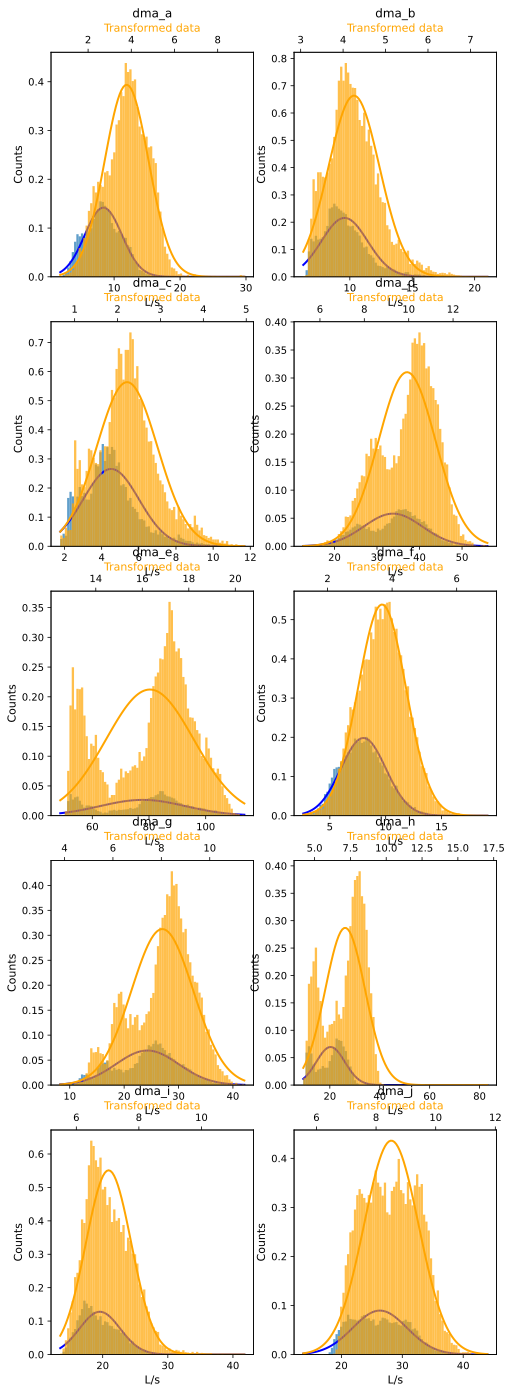

In [6]:
# box cox transform
bc_inflow_data = boxcox_transform(inflow_data[dmas])

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    
    # compare distributions of original and transformed data
    ax2 = axs[i].twiny()
    axs[i].set_title(dma)
    axs[i].hist(inflow_data[dma].values, density=True,bins=80,alpha=0.7)
    ax2.hist(bc_inflow_data[dma].values, density=True,bins=80, color='orange', alpha=0.7)
    
    # fit norm to original data
    # mean and standard deviation
    mu, std = norm.fit(inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = inflow_data[dma].min(), inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'blue', linewidth=2)
    
    # fit norm to transformed data
    # mean and standard deviation
    mu, std = norm.fit(bc_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = bc_inflow_data[dma].min(), bc_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    ax2.plot(x, p, 'orange', linewidth=2)
    
    axs[i].set_ylabel('Counts')
    axs[i].set_xlabel("L/s")
    ax2.set_xlabel("Transformed data", color='orange')

plt.show()
    

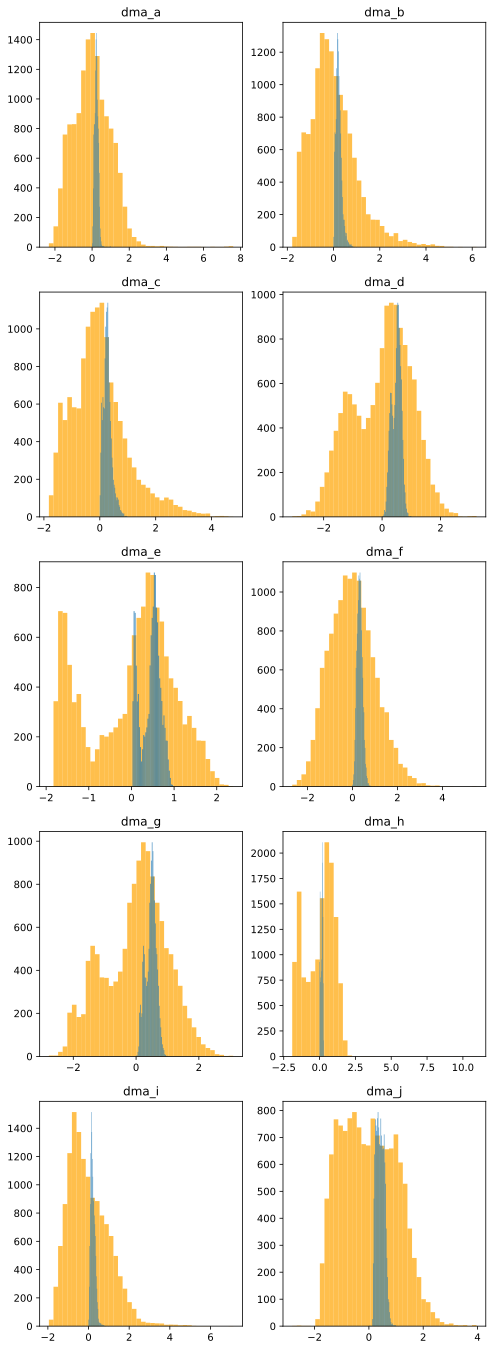

In [7]:
# box cox transform
norm_inflow_data = normalise(inflow_data[dmas])
std_inflow_data = standardise(inflow_data[dmas])

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    
    # compare distributions of original and transformed data
    axs[i].set_title(dma)
    axs[i].hist(std_inflow_data[dma].values, density=False,bins=40, color='orange', alpha=0.7)
    axs[i].hist(norm_inflow_data[dma].values, density=False,bins=40,alpha=0.7)
    
    """
    # fit norm to original data
    # mean and standard deviation
    mu, std = norm.fit(norm_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = norm_inflow_data[dma].min(), norm_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'blue', linewidth=2)
    
    # fit norm to transformed data
    # mean and standard deviation
    mu, std = norm.fit(std_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = std_inflow_data[dma].min(), std_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    ax2.plot(x, p, 'orange', linewidth=2)
    
    axs[i].set_ylabel('Counts')
    axs[i].set_xlabel("L/s")
    ax2.set_xlabel("Transformed data", color='orange')
    """

plt.show()


#### 1.2 Splitting data

In [16]:
# splitting data
train_start_dt = "2022-04-01 00:00:00"
inflow_df = inflow_data[(inflow_data.index >= train_start_dt)].copy()
weather_df = weather_data[(weather_data.index >= train_start_dt)].copy()

# percentage of data for each split
train_pc = 0.8
no_train = len(inflow_df) - 2*168 #int(train_pc * len(inflow_df))
test_pc = 0.2
no_vali = 168
no_test = 168 #int(test_pc * len(inflow_df))

train = inflow_df.iloc[0:no_train, :][dmas].copy()
vali = inflow_df.iloc[no_train:no_train+no_vali, :][dmas].copy()
test = inflow_df.iloc[no_train+no_vali:no_train+no_vali+no_test, :][dmas].copy()

train_exog = weather_df.iloc[0:no_train, :].copy()
test_exog = weather_df.iloc[no_train:no_train+no_test, :].copy()

print("Training data shape: ", train.shape)
print("Validation data shape: ", vali.shape)
print("Test data shape: ", test.shape)


Training data shape:  (2424, 10)
Validation data shape:  (168, 10)
Test data shape:  (168, 10)


#### 3. Averageing model

#### *3.1 Methods*

In [9]:
# FUNCTIONS
# Mean Day Impute
def SimpleMeanForecast(df, dma, stat='mean', res_window=20, train_window=2, p=0.95): 
    """
    Fills missing data values with the average for that day 
    and hour
    
    df - total dataframe of all dma
    dma - dma of interest
    res_window - period for rolling mean of residual
    train_window - length of training window in weeks
    
    """
    
    # exponential mean component
    avg_df = df[[dma]].copy() 
    avg_df = avg_df[-(train_window+1)*168::]
    avg_df['mean'] = 0
    avg_df['std_dev'] = 0
    avg_df['upper_conf'] = 0
    avg_df['lower_conf'] = 0
    
    # fill with nan mean for insufficient data for exponential
    avg_df['day'] = avg_df.index.weekday
    avg_df['hour'] = avg_df.index.hour
    
    if stat == 'mean': 
        avg_values = avg_df.groupby(by=['day', 'hour']).mean()[dma]
    elif stat == 'median': 
        avg_values = avg_df.groupby(by=['day', 'hour']).median()[dma]
        
    for idx, row in avg_df.iterrows(): 
        avg_df.loc[idx, 'mean'] = avg_values.loc[row.day, row.hour]
        
    std_vals = avg_df.groupby(by=['day', 'hour'])[[dma]].std()
    avg_df['std'] = [std_vals.loc[(x['day'],x['hour'])][0] for _,x in avg_df.iterrows()]
    
    # residual correction component
    avg_df['residual'] = avg_df[dma] - avg_df['mean']
    avg_df['residual'] = avg_df['residual'].fillna(method='ffill')
    avg_df['res_correction'] = avg_df['residual'].rolling(window=res_window, min_periods=1).mean()
    avg_df['mean'] = avg_df['mean'] + avg_df['res_correction'].fillna(1000)
    
    # set confidence bounds
    for i in avg_df.index: 
        ci = norm.interval(confidence=p, loc=avg_df.loc[i, 'mean'], scale=avg_df.loc[i, 'std'])
        avg_df.loc[i, 'upper_conf'] = ci[1]
        avg_df.loc[i, 'lower_conf'] = ci[0]
    
    return avg_df['mean'], avg_df['upper_conf'], avg_df['lower_conf']


def MeanDayImpute(df, dma, lag=3, memory=0.4, res_window=10, p=0.95): 
    """
    Fills missing data values with the average for that day 
    calcuated as an exponential average of the past (lag)
    occurances for that time and day.
    
    df - total dataframe of all dma
    dma - dma of interest
    lag - number of past values averaged
    memory - importance of recent values
    res_window - window used to average rolling residual
    
    """
    
    # exponential mean component
    avg_df = df[[dma]].copy() 
    avg_df['mean'] = 0
    avg_df['std_dev'] = 0
    
    for delta in np.arange(lag, 0, -1):
        avg_df[dma+str(delta)] = avg_df[dma].shift(24*7*delta)
        
        if delta == lag: 
            avg_df['mean'] = avg_df[dma+str(delta)]
        else:
            avg_df['mean'] = avg_df['mean']*(1-memory) + avg_df[dma+str(delta)]*memory
        
    # finding std of each day and hour for confidence bands (assuming norm)
    avg_df['day'] = avg_df.index.weekday
    avg_df['hour'] = avg_df.index.hour
    avg_vals = avg_df.groupby(by=['day', 'hour']).mean()[dma]
    
    std_vals = avg_df.groupby(by=['day', 'hour'])[[dma]].std()
    avg_df['std'] = [std_vals.loc[(x['day'],x['hour'])][0] for _,x in avg_df.iterrows()]
    
    # residual correction component
    avg_df['residual'] = avg_df[dma] - avg_df['mean']
    avg_df['res_correction'] = avg_df['residual'].rolling(window=res_window, min_periods=1, win_type='exponential').mean()
    avg_df['mean'] = avg_df['mean'] + avg_df['res_correction'].fillna(0)
    
    for idx in avg_df[avg_df['mean'].isna()].index: 
        avg_df.loc[idx, 'mean'] = avg_vals.loc[idx.weekday(), idx.hour]
    
    # set confidence bounds
    for i in avg_df.index: 
        ci = norm.interval(p, loc=avg_df.loc[i, 'mean'], scale=avg_df.loc[i, 'std'])
        print(ci)
        avg_df.loc[i, 'upper_conf'] = ci[1]
        avg_df.loc[i, 'lower_conf'] = ci[0]
    
    return avg_df['mean'], avg_df['upper_conf'], avg_df['lower_conf']


# Correlation Partners
def CorrPartner(data, thresh=0.7, period=12):
    """
    Finds dmas which have a correlation over the threshold
    across the specified period in weeks
    
    thresh - correlation threshold for partner to be considered
    period - number of weeks to consider correlation over
    
    """
    # Find comparison partner
    df = data.copy()
    correlation = df[df.index[-1]-dt.timedelta(weeks=period)::].corr()
    correlation = correlation[correlation!=1]
    partners = {
        dma: list(correlation[(correlation[dma]>=thresh)].index) 
        for dma in correlation.columns
    }
    
    return partners

def KmeanImpute(df, dma, partners, k=3): 
    """
    Imputes data using k means alogrithm for correlated dmas
    
    df - dataframe to impute
    k - number of neighbours
    dma - dma to impute
    
    """
    # Initialize the KNN imputer with k=5
    imputer = KNNImputer(n_neighbors=k)
    cols = partners[dma]+[dma]  # correlated partner set
    
    return imputer.fit_transform(df[cols])

#### *3.2 Optimise training window*

In [17]:
# optimising for training window#### *3.2 Run*
from utils.metrics import scores

results_a = vali.copy()
metric = 'MAPE'
train_windows = np.arange(1, 20, 2)
opt_df = pd.DataFrame(columns=train.columns, index=train_windows)

for window in train_windows: 
    print(f"Running for {window} week train window...")
    results_opt = vali.copy()

    # iterate over dmas
    for dma in dmas: 
        # preallocate space
        result_dma = train.copy()
        forecast_df = pd.DataFrame(columns=result_dma.columns, index=vali.index)
        result_dma = pd.concat([result_dma, forecast_df], axis=0)

        # get forecast for training window and dma
        forecast, upper, lower = SimpleMeanForecast(
            result_dma, 
            dma, 
            stat='mean', 
            res_window=168, 
            train_window=window
        )
        
        results_a[dma] = forecast
    
    for dma in dmas: 
        # get scores for each training window size
        opt_df.loc[window, dma] = scores(results_a[dma].values, vali[dma].values).loc[metric][0]


Running for 1 week train window...
Running for 3 week train window...
Running for 5 week train window...
Running for 7 week train window...
Running for 9 week train window...
Running for 11 week train window...
Running for 13 week train window...
Running for 15 week train window...
Running for 17 week train window...
Running for 19 week train window...


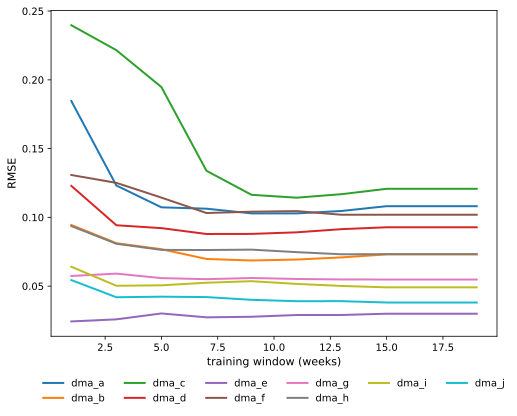

In [11]:
# plot optimisation results
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(opt_df, linewidth=2, label=opt_df.columns)
ax.set_ylabel('RMSE')
ax.set_xlabel('training window (weeks)')
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
    fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
leg.get_frame().set_linewidth(0.5)
    
plt.show()


#### *3.3 Run*

Forecasting horizon: 168 hours
Running for dma_a...
Running for dma_b...
Running for dma_c...
Running for dma_d...
Running for dma_e...
Running for dma_f...
Running for dma_g...
Running for dma_h...
Running for dma_i...
Running for dma_j...


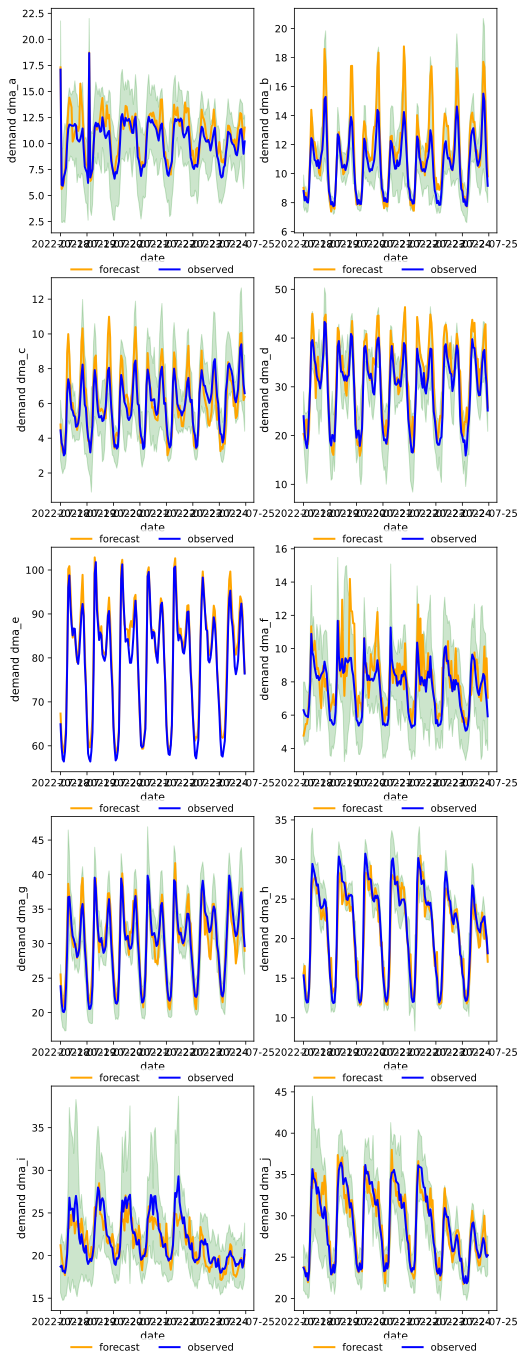

In [18]:
# apply results
HORIZON = no_test
print("Forecasting horizon:", HORIZON, "hours")

results_a = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()

# iterate over dmas
for dma in dmas: 
    print(f"Running for {dma}...")

    result_dma = pd.concat([train, vali])
    forecast_df = pd.DataFrame(columns=result_dma.columns, index=test.index)
    result_dma = pd.concat([result_dma, forecast_df], axis=0)
    
    forecast, upper, lower = SimpleMeanForecast(
        result_dma, 
        dma, 
        stat='mean', 
        res_window=168, 
        train_window=max(1, opt_df[opt_df[dma]==opt_df[dma].min()].index[0]-1)
    )
    
    ci_lower[dma] = lower
    ci_upper[dma] = upper
    results_a[dma] = forecast

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    axs[i].plot(test[dma], 'orange', linewidth=2, label='forecast')
    axs[i].plot(results_a[dma], 'blue', linewidth=2, label='observed')
    axs[i].fill_between(results_a.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)
    
    axs[i].set_ylabel(f"demand {dma}")
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
plt.show()
    

#### *3.3 Metrics*

In [19]:
# metrics
from utils import metrics

mape = {dma: metrics.mape(results_a[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_a[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_a[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)

{'dma_a': 0.09660942732741054, 'dma_b': 0.08370215229022346, 'dma_c': 0.10695720059699765, 'dma_d': 0.10729340634801666, 'dma_e': 0.02694208152288578, 'dma_f': 0.11929913070732676, 'dma_g': 0.042821495889771986, 'dma_h': 0.05915368668313093, 'dma_i': 0.05131621834045902, 'dma_j': 0.04038424949506819, 'total': 0.7344790492012909}


#### 4. Naive forecasting

#### *4.1 Run*

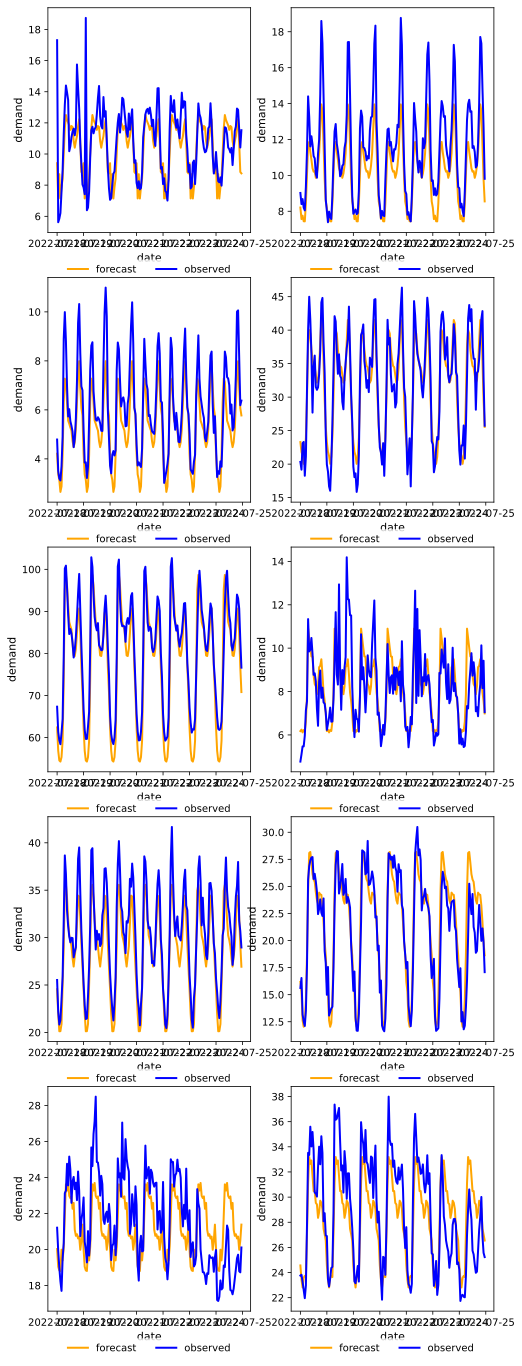

In [20]:
# imports
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

# make empty datafram to store results
results_b = test.copy()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(dmas):
    
    # retrieve optimal training window
    opt_train_window = max(opt_df[opt_df[dma]==opt_df[dma].min()].index[0]-1, 1)*168 
    
    # use both train and validation set for training
    y_train = pd.concat([train[dma][opt_train_window:], vali[dma]])
    y_test = test[dma].copy()

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean', sp=24)
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)
    results_b[dma] = y_pred_naive

    axs[i].plot(y_pred_naive, color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
plt.show()
    

#### *4.2 Metrics*

In [21]:
# print metrics
mape = {dma: metrics.mape(results_b[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_b[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_b[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)

{'dma_a': 0.10363671669059504, 'dma_b': 0.12032508952564523, 'dma_c': 0.1581637540004015, 'dma_d': 0.07772240214542406, 'dma_e': 0.05037294099139432, 'dma_f': 0.10645758644175138, 'dma_g': 0.06566905299011247, 'dma_h': 0.06777417546515926, 'dma_i': 0.08033832448849199, 'dma_j': 0.07273068583758187, 'total': 0.9031907285765572}


#### 5. AutoRegressive Model

In [22]:
# imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [49]:
# get diurnal flow
inflow_diurnal_df = inflow_df

for dma in dmas: 
    
    forecast, upper, lower = SimpleMeanForecast(
        inflow_df, 
        dma, 
        stat='mean', 
        res_window=24, 
        train_window=len(inflow_diurnal_df)
    )
    
    inflow_diurnal_df[dma] = forecast 


In [50]:
# splitting data
train_start_dt = "2022-04-01 00:00:00"
inflow_df = inflow_data[(inflow_data.index >= train_start_dt)].copy()
weather_df = weather_data[(weather_data.index >= train_start_dt)].copy()

# percentage of data for each split
train_pc = 0.8
no_train = len(inflow_df) - 168 #int(train_pc * len(inflow_df))
test_pc = 0.2
no_test = 168 #int(test_pc * len(inflow_df))

train = inflow_df.iloc[0:no_train, :][dmas].copy()
test = inflow_df.iloc[no_train:no_train+no_test, :][dmas].copy()

train_diurnal = inflow_diurnal_df.iloc[0:no_train, :][dmas].copy()
test_diurnal = results_a

train_exog = weather_df.iloc[0:no_train, :].copy()
test_exog = weather_df.iloc[no_train:no_train+no_test, :].copy()

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)


Training data shape:  (2592, 10)
Test data shape:  (168, 10)


In [51]:
"""
import statsmodels.api as sm
import pylab as py
sm.qqplot(inflow_df['dma_a'],line='45')
py.show()
#Results show not normally distributed

from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(inflow_df['dma_a'], dist=stats.norm,plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
flow2,_= stats.boxcox(inflow_df['dma_a'])
prob = stats.probplot(flow2, dist=stats.norm,plot=ax2)
ax2.set_title('Probplot after Box-Cox')
plt.show()
"""


"\nimport statsmodels.api as sm\nimport pylab as py\nsm.qqplot(inflow_df['dma_a'],line='45')\npy.show()\n#Results show not normally distributed\n\nfrom scipy import stats\nfig = plt.figure()\nax1 = fig.add_subplot(211)\nprob = stats.probplot(inflow_df['dma_a'], dist=stats.norm,plot=ax1)\nax1.set_xlabel('')\nax1.set_title('Probplot against normal distribution')\n\nax2 = fig.add_subplot(212)\nflow2,_= stats.boxcox(inflow_df['dma_a'])\nprob = stats.probplot(flow2, dist=stats.norm,plot=ax2)\nax2.set_title('Probplot after Box-Cox')\nplt.show()\n"

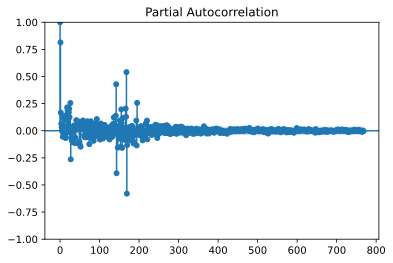

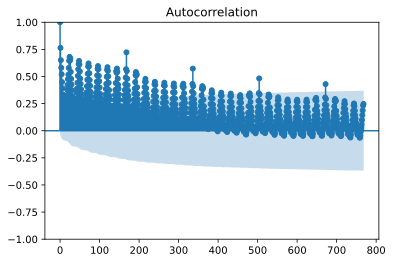

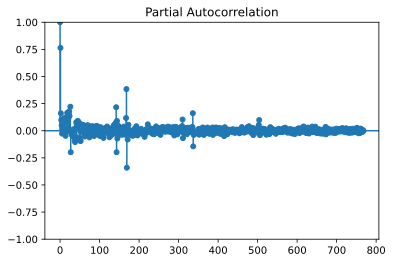

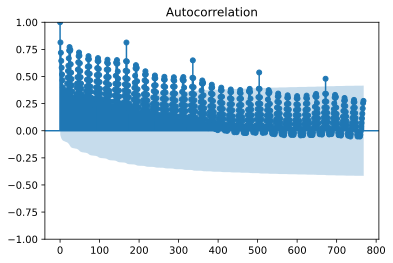

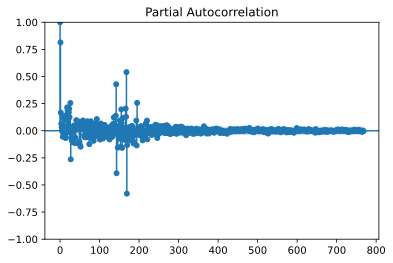

In [52]:
#Autocorrelation for (flow)
plot_acf(inflow_df['dma_a'],lags = 96*8)
plot_pacf(inflow_df['dma_a'],lags = 96*8)

#Autocorrelation for (flow - diurnal flow)
plot_acf(inflow_diurnal_df['dma_a'],lags = 96*8)
plot_pacf(inflow_diurnal_df['dma_a'],lags = 96*8)


#### 5. (a) ARIMA (with diurnal flow as exog)

In [96]:
# auto arima model
arima_params = {dma: () for dma in dmas}

for dma in dmas: 
    arima_d = ndiffs(inflow_df[dma],max_d = 12)
    arima_model = auto_arima(inflow_df[dma], d = arima_d, 
                             exogenous = inflow_diurnal_df[dma],
                             seasonal=True, trace=True,
                             error_action = 'ignore',
                             suppress_warnings=True,stepwise= True,
                             n_fits = 50, method = 'nm')

    arima_params[dma] = arima_model.get_params()['order']

arima_params

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11148.442, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11662.178, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11470.563, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11386.270, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11660.182, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11342.896, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11181.235, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11655.852, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11504.512, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11172.057, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11326.094, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11353.542, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11665.265, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11146.624, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9832.115, Time=0.37 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.382 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12216.202, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13739.382, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12972.905, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13048.236, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13737.386, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13052.052, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13733.449, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13736.833, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13740.014, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12938.916, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13694.324, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13705.976, Time=0.40 sec
 ARIMA(3,1

{'dma_a': (1, 1, 1),
 'dma_b': (2, 1, 1),
 'dma_c': (2, 1, 1),
 'dma_d': (2, 1, 2),
 'dma_e': (2, 1, 1),
 'dma_f': (1, 1, 1),
 'dma_g': (2, 1, 2),
 'dma_h': (2, 0, 1),
 'dma_i': (1, 1, 1),
 'dma_j': (1, 1, 0)}

Running for dma_a...
Running for dma_b...
Running for dma_c...
Running for dma_d...
Running for dma_e...
Running for dma_f...
Running for dma_g...
Running for dma_h...
Running for dma_i...
Running for dma_j...


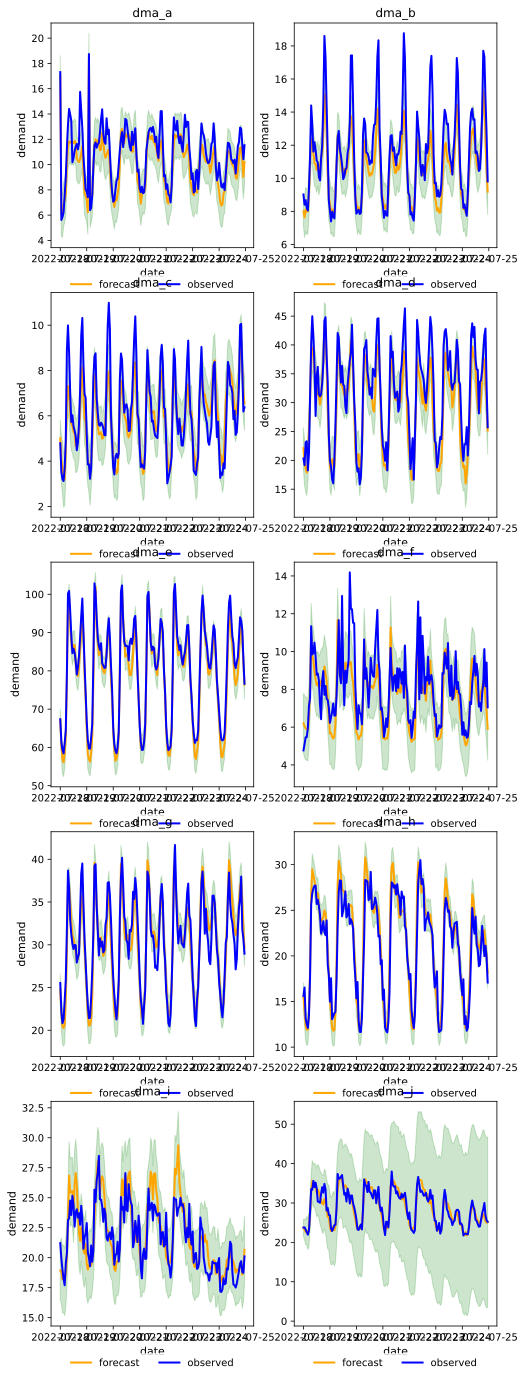

In [97]:
#ARIMAX Model
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()

fig, axs = plt.subplots(5,2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    print(f"Running for {dma}...")
    model_arimax = ARIMA(train[dma],
                          order = arima_params[dma], 
                          exog = train_diurnal[dma],
                          freq = None
                        )
    result_arimax=model_arimax.fit()

    #Train prediction
    trainPredict_arimax = (result_arimax.predict(0,len(train)-1)).fillna(0)

    #Test Prediction
    forecast_arimax = result_arimax.get_prediction(len(train),len(inflow_df)-1,exog=test_diurnal[dma])
    testPredict_arimax = forecast_arimax.predicted_mean
    testPredict_arimax_ci = forecast_arimax.conf_int(alpha=0.1)

    # extract forecast
    results_c[dma] = testPredict_arimax
    ci_lower[dma] = testPredict_arimax_ci['lower '+dma]
    ci_upper[dma] = testPredict_arimax_ci['upper '+dma]

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(test[dma], color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_title(dma)
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    
plt.show()


#### *5.2 Metrics*

In [98]:
# print metrics
mape = {dma: metrics.mape(test[dma], results_c[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_c[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_c[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)


{'dma_a': 0.08420607328459162, 'dma_b': 0.07787554431110967, 'dma_c': 0.10587215605200645, 'dma_d': 0.09394076843710641, 'dma_e': 0.0256621103733435, 'dma_f': 0.10647213155902348, 'dma_g': 0.04216580050218962, 'dma_h': 0.0604279128150674, 'dma_i': 0.05281664100743039, 'dma_j': 0.03988840492894999, 'total': 0.6893275432708185}


In [ ]:
"""
#Save excel
excel_name = 'ARIMAX.xlsx'

df_results_test = pd.DataFrame({
            "testPredict":testPredict_arimax.tolist(),
            "testlower":testPredict_arimax_ci.iloc[:,0].tolist(),
            "testupper":testPredict_arimax_ci.iloc[:,1].tolist(),
            })

with pd.ExcelWriter(excel_name) as writer:
    df_results_test.to_excel(writer,index=False,sheet_name='Test')
"""

#### 5. (b) ARIMA (with diurnal flow subtracted)

In [90]:
# auto arima model
arima_params = {dma: () for dma in dmas}

for dma in dmas: 
    arima_d = ndiffs(inflow_df[dma]-inflow_diurnal_df[dma],max_d = 12)
    arima_model = auto_arima(inflow_df[dma]-inflow_diurnal_df[dma], d = arima_d, 
                             seasonal=True, trace=True,
                             error_action = 'ignore',
                             suppress_warnings=True,stepwise= True,
                             n_fits = 50, method = 'nm')

    arima_params[dma] = arima_model.get_params()['order']

arima_params

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7409.368, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8080.001, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7416.586, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7533.605, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8078.757, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7407.926, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=7457.626, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7415.560, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=7403.740, Time=0.49 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=7447.839, Time=0.43 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7387.439, Time=0.44 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7372.381, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8076.576, Time=0.45 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=7373.108, Time=0.45 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10655.983, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10612.038, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10604.847, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10601.979, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10797.937, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10621.962, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10600.662, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=12375.858, Time=0.36 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 5.530 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7548.723, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7874.811, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7605.625, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7670.502, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7872.848, Time=0.03 sec
 ARIMA(1,0,2)(

{'dma_a': (5, 0, 5),
 'dma_b': (2, 0, 2),
 'dma_c': (2, 0, 1),
 'dma_d': (1, 0, 4),
 'dma_e': (2, 0, 1),
 'dma_f': (2, 0, 2),
 'dma_g': (2, 0, 2),
 'dma_h': (1, 0, 2),
 'dma_i': (1, 0, 2),
 'dma_j': (5, 0, 0)}

Running for dma_a...
Running for dma_b...
Running for dma_c...
Running for dma_d...
Running for dma_e...
Running for dma_f...
Running for dma_g...
Running for dma_h...
Running for dma_i...
Running for dma_j...


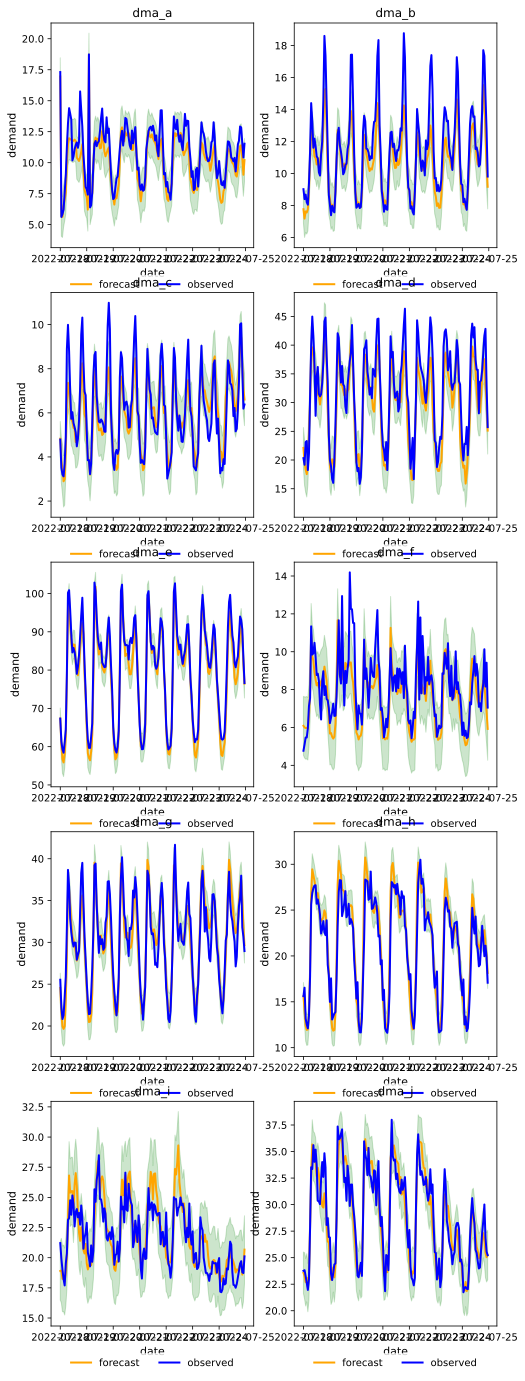

In [91]:
#ARIMAX Model
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()

fig, axs = plt.subplots(5,2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    print(f"Running for {dma}...")
    model_arima = ARIMA(train[dma]-train_diurnal[dma],
                          order = arima_params[dma], 
                          freq = None
                        )
    result_arima=model_arima.fit()

    #Train prediction
    trainPredict_arima = (result_arima.predict(0,len(train)-1)).fillna(0)

    #Test Prediction
    forecast_arima = result_arima.get_prediction(len(train),len(inflow_df)-1)
    testPredict_arima = forecast_arima.predicted_mean+test_diurnal[dma]
    testPredict_arima_ci = forecast_arima.conf_int(alpha=0.1)
    testPredict_arima_ci.iloc[:,0] = testPredict_arima_ci.iloc[:,0]+test_diurnal[dma]
    testPredict_arima_ci.iloc[:,1] = testPredict_arima_ci.iloc[:,1]+test_diurnal[dma]

    # extract forecast
    results_c[dma] = testPredict_arima
    ci_lower[dma] = testPredict_arima_ci['lower '+dma]
    ci_upper[dma] = testPredict_arima_ci['upper '+dma]

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(test[dma], color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_title(dma)
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    
plt.show()

In [92]:
# print metrics
mape = {dma: metrics.mape(test[dma], results_c[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_c[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_c[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)

{'dma_a': 0.08372404330959221, 'dma_b': 0.0755717873814191, 'dma_c': 0.10545457439322826, 'dma_d': 0.09413444946378453, 'dma_e': 0.025615660751377417, 'dma_f': 0.10559639368199888, 'dma_g': 0.04324656874821939, 'dma_h': 0.0601553015746647, 'dma_i': 0.05254732530013769, 'dma_j': 0.03982651412662727, 'total': 0.6858726187310495}


#### 5. (a) SARIMA

In [1]:
# auto arima model
arima_params = {dma: () for dma in dmas}

for dma in dmas: 
    arima_d = ndiffs(inflow_df[dma]-inflow_diurnal_df[dma],max_d = 12)
    arima_model = auto_arima(inflow_df[dma]-inflow_diurnal_df[dma], d = arima_d, 
                             seasonal=True, m=24, trace=True,
                             error_action = 'ignore',
                             suppress_warnings=True,stepwise= True,
                             n_fits = 50, method = 'nm')

    arima_params[dma] = arima_model.get_params()['order']

arima_params

NameError: name 'dmas' is not defined

In [ ]:
# make empty datafram to store results
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()
residuals_train = pd.DataFrame()
residuals_test = pd.DataFrame()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(['dma_a']):
    print(f"Running for {dma}...")
    
    y_train = train[dma].copy()
    y_test = test[dma].copy()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.
    model = SARIMAX(y_train, order=(2,0,2), seasonal_order=(0,1,1,24*7)) # add seasonality of 24 hrs
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(len(y_test)).summary_frame(alpha=0.05)

    results_c[dma] = y_pred['mean']
    ci_lower[dma] = y_pred['mean_ci_lower']
    ci_upper[dma] = y_pred['mean_ci_upper']
    residuals_train[dma] = model_fit.resid
    residuals_test[dma] = test[dma] - y_pred['mean']

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, sshadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    

plt.show()

### Result Analysis

In [ ]:
# imports

# get residuals from SARIMAX
for dma in ['dma_a']: 
    train_exog[dma+'_residual'] = residuals_train[dma]
    train_exog[dma] = train[dma]
    
train_exog['day'] = train_exog.index.weekday
train_exog['hour'] = train_exog.index.hour

# get correlations
train_exog.corr()


In [ ]:
# plot residuals
fig, axs = plt.subplots(5, 2, figsize=(8, 16))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    axs[i].plot(residuals_train[dma][-2000:], linewidth=2, color='blue', label='train')
    axs[i].plot(residuals_test[dma], linewidth=2, color='orange', label='test')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('residual')
    axs[i].set_title('SARIMA residuals')

fig.tight_layout()
plt.show()


In [ ]:
# plotting weekday averages of residuals
days = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']

colors = [
    "#FF0000",  # Red
    "#0000FF",  # Blue
    "#00FF00",  # Green
    "#FFA500",  # Orange
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#800000",  # Maroon
    "#008000",  # Dark Green
    "#000080"   # Navy
]

fig, axs = plt.subplots(5, 2, figsize=(10, 16))
axs = axs.flatten()

fig.suptitle('Average daily variation by dma by day', fontsize=12)

for i, dma in enumerate(['dma_a']):
    for day in np.arange(0,7): 
        mean = train_exog[train_exog['day']==day].groupby(by='hour')[[dma+'_residual']].mean()
        std = train_exog[train_exog['day']==day].groupby(by='hour')[[dma+'_residual']].std()
        lb = mean-1.96*std
        ub = mean+1.96*std
        axs[i].plot(mean, label=days[day], color=colors[day-1])
        axs[i].fill_between(lb.index, np.array(ub.T)[0], np.array(lb.T)[0], alpha=0.2, color=colors[day-1])
        
        axs[i].set_title(dma)
        axs[i].set_xlabel('hour')
        axs[i].set_ylabel('residuals')
        leg = axs[i].legend(loc='right', bbox_to_anchor=(1, 0.5),
            fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()


In [ ]:
# plotting residual correlation to different exogeneous factors
import random

fig, axs = plt.subplots(10, 2, figsize=(8, 24))

factors = ['demand', 'air_temp']

fig.suptitle('Correlation between resid, demand, and temp', fontsize=12, y=1)

for i, dma in enumerate(dmas):
    for j, factor in enumerate(factors): 
        
        sample = pd.DataFrame()
        sample['x'] = train_exog[dma+'_residual']
        if factor == 'demand': 
            sample['y'] = train_exog[dma]
        else: 
            sample['y'] = train_exog[factor]
            
        sample = sample.dropna()
        
        # Plotting the histogram.
        axs[i][j].scatter(sample['x'], sample['y'], s=60, alpha=0.7, edgecolors="k")
        
        # get correlation
        corr = np.corrcoef(sample['x'], sample['y'])[0][1]

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(sample['x'], sample['y'], deg=1)
        
        xmin, xmax = 0, inflow_data[dma].max() * 1.2
        
        # Create sequence of 100 numbers from 0 to 100 
        xseq = np.linspace(xmin, xmax, num=100)

        # Plot regression line
        axs[i][j].plot(xseq, a + b * xseq, color="k", lw=1);
    
        axs[i][j].set_title(dma + ' : corr ' + repr(corr)[:3] + ': '+factor)
        axs[i][j].set_xlabel('residual')
        axs[i][j].set_ylabel(factor)

fig.tight_layout()
plt.show()

In [ ]:
# plotting demand correlation to prior timesteps of importance
import random

fig, axs = plt.subplots(10, 3, figsize=(12, 24))

lags = [1, 24, 24*7]

fig.suptitle('Correlation between demand at t, t-1, t-24, and t-24*7 ', fontsize=12, y=1)

for i, dma in enumerate(dmas):
    for j, lag in enumerate(lags): 
        
        data = inflow_data.dropna()[0:3000]
        
        sample = pd.DataFrame()
        sample['x'] = train_exog[dma+'_residual']
        sample['y'] = train_exog.shift(lag)[dma+'_residual']
        sample = sample.dropna()
        
        # Plotting the histogram.
        axs[i][j].scatter(sample['x'], sample['y'], s=60, alpha=0.7, edgecolors="k")
        
        # get correlation
        corr = np.corrcoef(sample['x'], sample['y'])[0][1]

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(sample['x'], sample['y'], deg=1)
        
        xmin, xmax = 0, inflow_data[dma].max() * 1.2
        
        # Create sequence of 100 numbers from 0 to 100 
        xseq = np.linspace(xmin, xmax, num=100)

        # Plot regression line
        axs[i][j].plot(xseq, a + b * xseq, color="k", lw=1);
    
        axs[i][j].set_title(dma + ' : corr ' + repr(corr)[:3] + ': t-' + str(lag))
        axs[i][j].set_xlabel('residual')
        axs[i][j].set_ylabel('lag')

fig.tight_layout()
plt.show()

In [ ]:
# plotting dma demand distributions vs normal
from scipy.stats import norm

fig, axs = plt.subplots(5, 2, figsize=(8, 12))
axs = axs.flatten()

fig.suptitle('Average daily variation by dma by month', fontsize=12)

for i, dma in enumerate(dmas):
    # Plotting the histogram.
    axs[i].hist(train_exog[dma+'_residual'], bins=40, density=True, alpha=0.6, color='b')
    
    # Fit a normal distribution to
    # the data:
    # mean and standard deviation
    mu, std = norm.fit(train_exog[dma+'_residual'].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = train_exog[dma+'_residual'].min() * 1.2, train_exog[dma+'_residual'].max() * 1.2
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'k', linewidth=2)
    axs[i].set_title(dma)
    axs[i].set_xlabel('residual')
    axs[i].set_ylabel('frequency density')

fig.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 16))
axs = axs.flatten()

fig.suptitle('Average daily residual variation by dma by month', fontsize=12)

for i, dma in enumerate(dmas):
    axs[i].plot(train_exog[train_exog['day']==5].groupby(by='hour').mean()[dma+'_residual'], label='Sat')
    axs[i].plot(train_exog[train_exog['day']==6].groupby(by='hour').mean()[dma+'_residual'], label='Sun')
    axs[i].plot(train_exog[train_exog['official_holiday']==1].groupby(by='hour').mean()[dma+'_residual'], label='Off. Hol.')
    axs[i].plot(train_exog[train_exog['legally_not_recongnized_holidays']==1].groupby(by='hour').mean()[dma+'_residual'], label='Non-Legal Hol.')
    axs[i].plot(train_exog[train_exog['event_day']==1].groupby(by='hour').mean()[dma+'_residual'], label='Event Day')
    axs[i].plot(train_exog.groupby(by='hour').mean()[dma+'_residual'], label='Avg. Day')
    
    axs[i].set_title(dma)
    axs[i].set_xlabel('hour')
    axs[i].set_ylabel('residual')
    leg = axs[i].legend(loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()

#### 7. SARIMAX (weather/imputing)

In [ ]:
# imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# make empty datafram to store results
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()
residuals_train = pd.DataFrame()
residuals_test = pd.DataFrame()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(['dma_a']):
    print(f"Running for {dma}...")
    
    y_train = train[dma].copy()
    y_test = test[dma].copy()
    
    x_train = train_exog['air_temp'].copy()
    x_test = test_exog['air_temp'].copy()
    
    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.
    model = SARIMAX(y_train, exog=x_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(len(y_test), exog=x_test).summary_frame(alpha=0.05)

    results_c[dma] = y_pred['mean']
    ci_lower[dma] = y_pred['mean_ci_lower']
    ci_upper[dma] = y_pred['mean_ci_upper']
    residuals_train[dma] = model_fit.resid
    residuals_test[dma] = test[dma] - y_pred['mean']

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    

plt.show()

In [ ]:
# print metrics
mape = {dma: metrics.mape(results_c[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_c[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_c[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)


In [ ]:
training_window = 24

# comparison of prediction and actual
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()
    
for i,dma in enumerate(dmas): 
    train_ts = train[dma]
    test_ts = dma_dfs[dma]

    history = [x for x in train_ts]
    history = history[(-training_window):]

    predictions = list()

    # run autoreg model for each dma
    for t in range(test_ts.shape[0]):
        model = AutoReg(history, 1)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=3)
        predictions.append(yhat[0])
        obs = list(test_ts.iloc[t])
        history.append(obs[0])
        history.pop(0)
        
    axs[i].plot(train_ts[-training_window:], 'blue', linewidth=2, label='Observations')    
    axs[i].plot(test_ts.index, test_ts, 'blue', linewidth=2, label='Observations')
    axs[i].plot(test_ts.index, predictions, 'orange', linewidth=2, label='Predicted')
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel("hours")
        
    leg = axs[i].legend(loc='right', bbox_to_anchor=(1.2, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0)
    leg.get_frame().set_linewidth(0.5)
    

### Modelling Residuals

#### 1. Univariate GRU

In [ ]:
# create train, vali, and test sets
train_exog

In [ ]:
# NN parameters required in data prep
T = 168
HORIZON = 168





## OTHER CODE

In [ ]:
HORIZON = no_test
print("Forecasting horizon:", HORIZON, "hours")

results_a = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()

# iterate over dmas
for dma in ['dma_a']: 
    print(f"Running for {dma}...")
    result_dma = train.copy()
    # forecast 1 step at a time
    for i in np.arange(HORIZON): 
        forecast, upper, lower = MeanDayImpute(
            result_dma, 
            dma, 
            lag=6, 
            memory=0.4, 
            res_window=10
        )
    
        result_dma = pd.concat([result_dma, test.iloc[[i]]], axis=0)
        result_dma[dma].iloc[-1] = forecast[-1]

    upper = upper
    lower = lower

    ci_lower[dma] = lower
    ci_upper[dma] = upper
    
    results_a[dma] = result_dma[dma]

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    axs[i].plot(test[dma], 'orange', linewidth=2, label='forecast')
    axs[i].plot(results_a[dma], 'blue', linewidth=2, label='observed')
    axs[i].fill_between(results_a.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)
    
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
plt.show()